# Refine an existing model around a new pumping well. Compare different refinement levels.
In this example we'll look at the impact that cell size has on the simulated drawdown
cone around a pumping well. The coarse structured grid of the existing structured grid
model will be converted to a vertex grid with quadtree refinement around a pumping well.
Refinement levels will range from the existing cell size to less than 1 meter.

Import libaries

In [75]:
# IMPORT
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import flopy
from mfmodify import get_sp_data, scenario_from_repeat_years
from mfmodify.regrid import refine_and_add_wel
from mfmodify.plotting import (
    make_xs_line_along_dis_grid,
    plot_interpolated_ws
)

Set inputs

In [81]:
# INPUT
sim_ws_hist = os.path.join('historic_models', 'model_v1-metric')
new_sim_base_dir = os.path.join('regrid_tests', 'tvgwfm')
# pumping well
well_xy = (2312990, 1400989)
well_layer = 0
pump_rate = -2500

Make some helper functions

In [85]:
# FUNCTIONS
def plot_interpolated_heads(gwf, xs_line, ax, layer=0, grid=True, **kwargs):
    # get data
    kstpkper = gwf.output.head().get_kstpkper()[-1]
    # get heads
    lay_hds = (
        gwf
        .output
        .head()
        .get_data(kstpkper=kstpkper)[layer, :, :]
    )
    # get cross-section plotter
    xs = flopy.plot.PlotCrossSection(
        model=gwf,
        line={'line': xs_line},
        ax=ax,
        geographic_coords=True
    )
    # plot grid
    if grid:
        lc = xs.plot_grid(linewidth=0.5, alpha=0.5)
    # plot heads
    surf = xs.plot_surface(lay_hds, masked_values=[1e30], color="black", lw=0.0)
    # get centers of lines for interpolated surface plot
    int_surf_xs = []
    int_surf_ys = []
    for lines in surf:
        line = lines[0]
        xs, ys = line.get_data()
        int_surf_xs.append(xs.mean())
        int_surf_ys.append(ys.mean())
    # plot interpolated surface
    int_surf = ax.plot(int_surf_xs, int_surf_ys, **kwargs)
    return int_surf

def remove_axes(ax, x=True, y=True):
    if x:
        ax.xaxis.set_ticks([])
        ax.set_xlabel('')
    if y:
        ax.yaxis.set_ticks([])
        ax.set_ylabel('')
    return ax

Make a scenario of the last 5 years so the models run faster. This takes about 80 seconds on my laptop.

In [3]:
# load historic model
sim_orig = flopy.mf6.MFSimulation.load(sim_ws=sim_ws_hist, verbosity_level=0)
gwf_orig = sim_orig.get_model()
# get the model years and define the initial condition month and year
sp_hist = get_sp_data(sim_orig)
scen_years = sp_hist.year.unique()[-5:]
ic_mon_year = (12, scen_years[-1])
# set directory
sim_ws_base = os.path.join(new_sim_base_dir, 'base-last_5_years')
# make 5 year scenario
sim_scenavg = scenario_from_repeat_years(
    sim_ws_hist, 
    scen_years,
    ic_mon_year,
    new_sim_ws=sim_ws_base
)
# write and run
sim_scenavg.write_simulation(silent=True)
sim_scenavg.run_simulation(silent=True)

Loading simulation from historic_models\model_v1-metric
generating new simulation with modified sp and timeseries info


(True, [])

Create and run 11 refined versions of the 5-year scenario model. This took about 10 minutes on my laptop.

In [4]:
# loop over a bunch of refinement levels
for refine_level in range(1, 12):
    sim_ws_new = os.path.join(
        new_sim_base_dir, 
        f'last_5_years-refine_{refine_level}')
    sim_new, grid_relate, well_cellid  = refine_and_add_wel(
        sim_ws_base, 
        well_xy, 
        well_layer,
        refine_level, 
        pump_rate, 
        sim_ws_new=sim_ws_new
    )

Plot grids and drawdown cone of pumping well by showing heads around refined cell at the final stress period.

In [89]:
# Make a line for plotting cross-sections around the well (using helper function)
xs_line = make_xs_line_along_dis_grid(gwf_orig, well_xy, 2600, along='row')
xs_line

[(2315588.4161502495, 1400898.2613085734),
 (2310391.5838497505, 1401079.7386914266)]

In [90]:
# get all simulation folders
sim_folders = glob(os.path.join(new_sim_base_dir, 'last_5_years-refine_*'))
# sort
refine_levels = [int(f.split('_')[-1]) for f in sim_folders]
sim_folders_sorted = [x for _, x in sorted(zip(refine_levels, sim_folders))]
all_folders = [sim_ws_base] + sim_folders_sorted

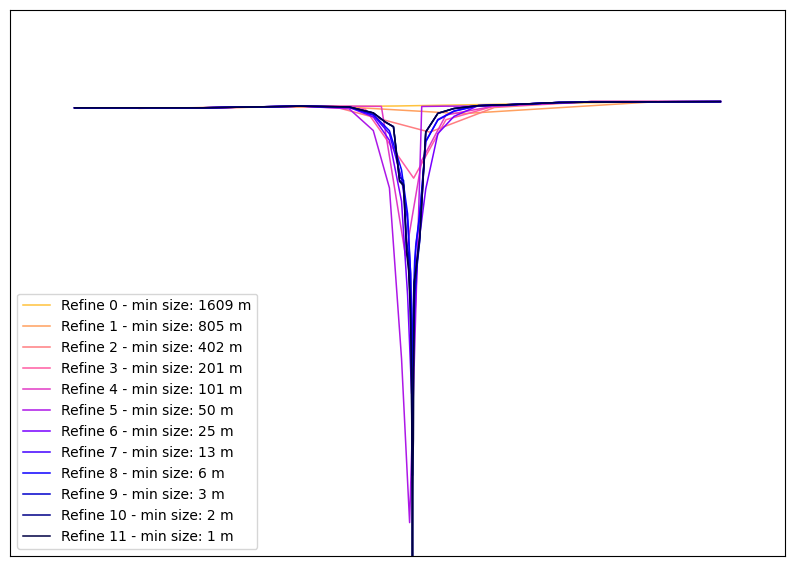

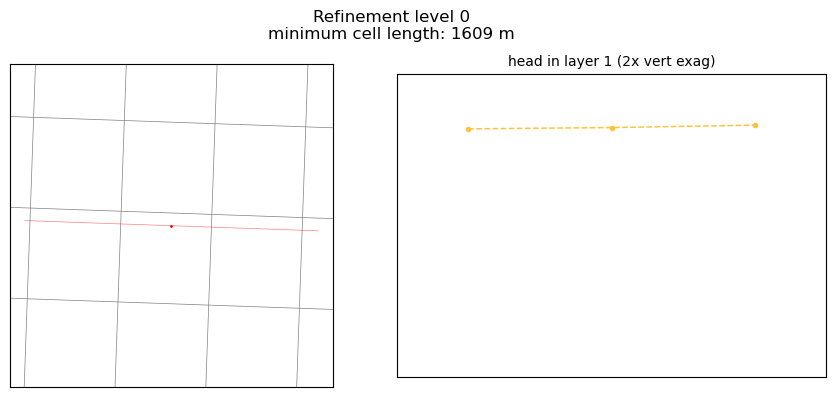

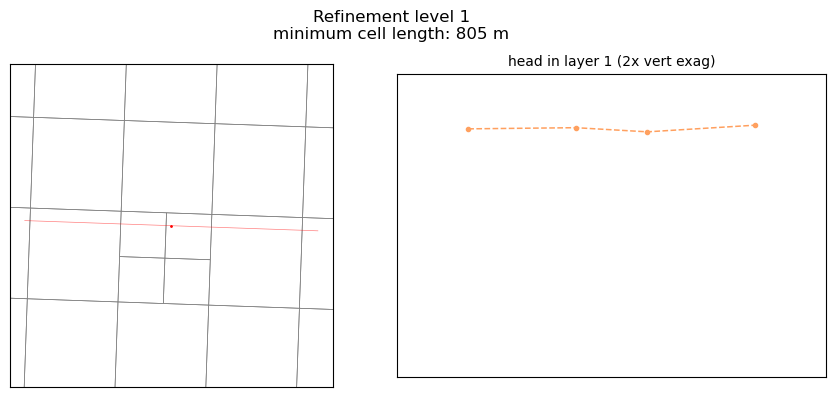

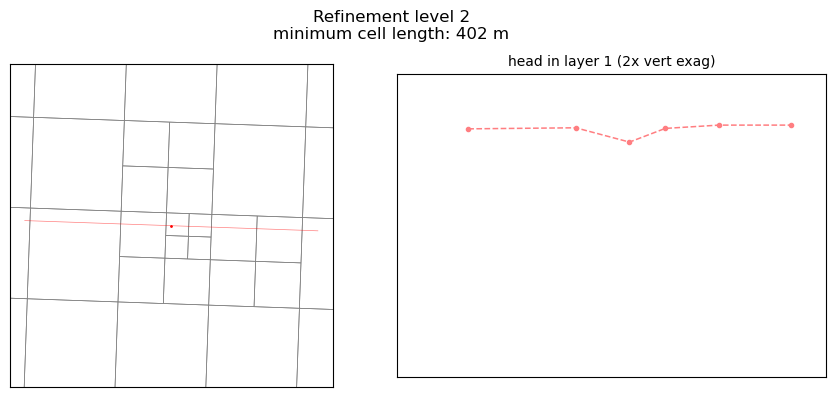

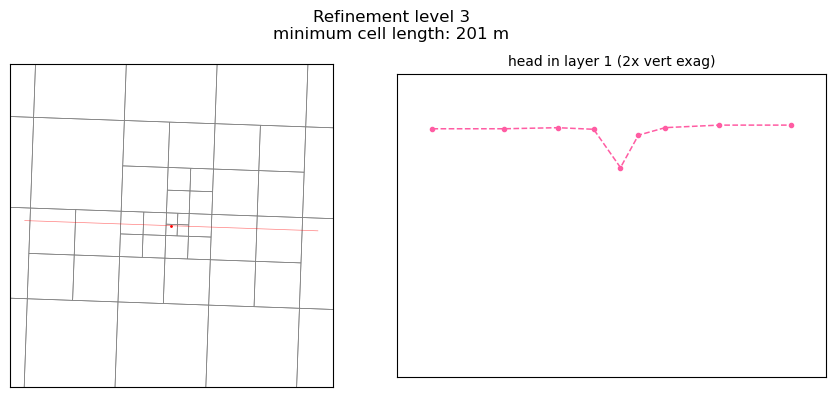

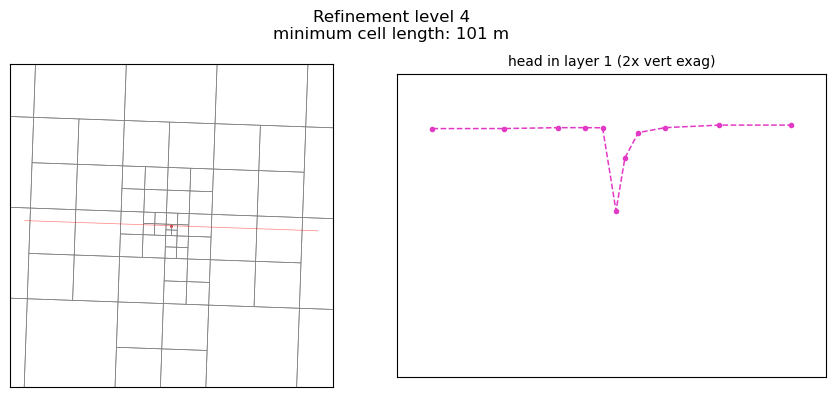

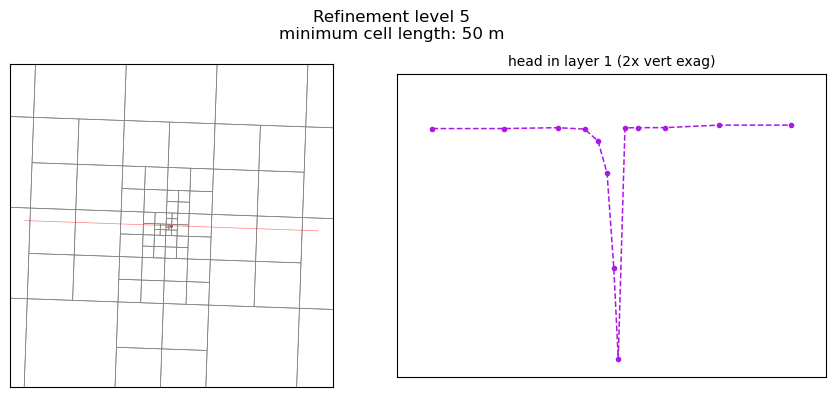

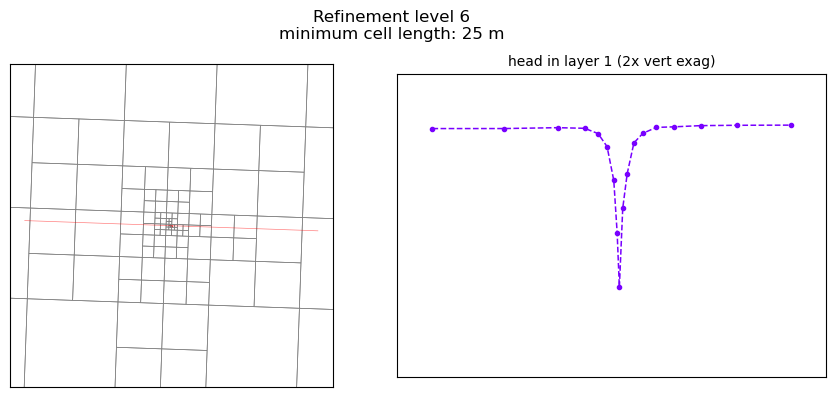

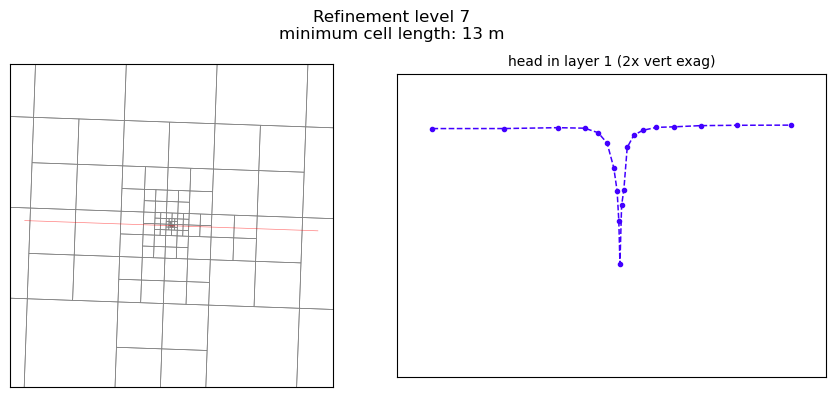

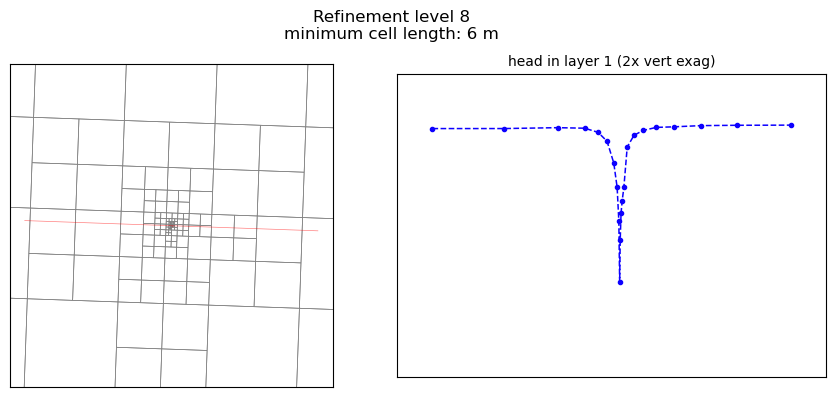

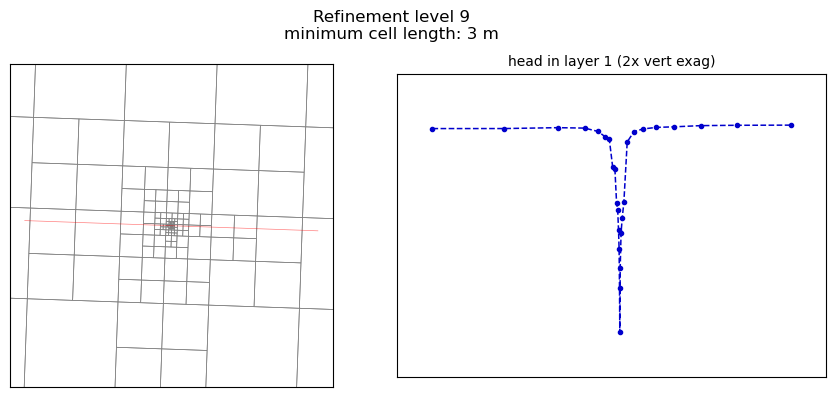

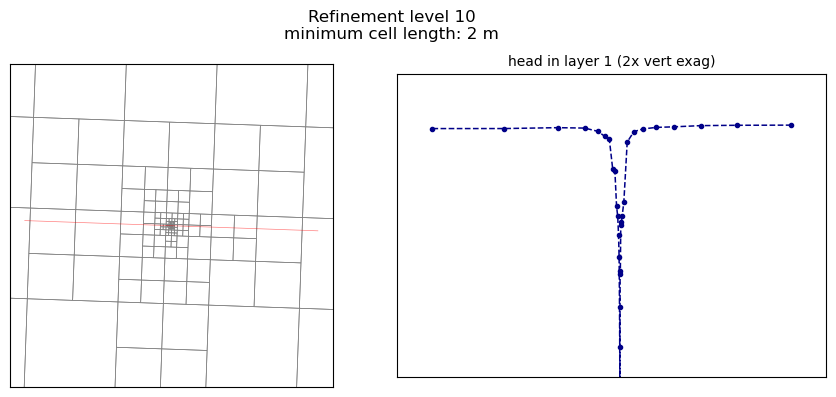

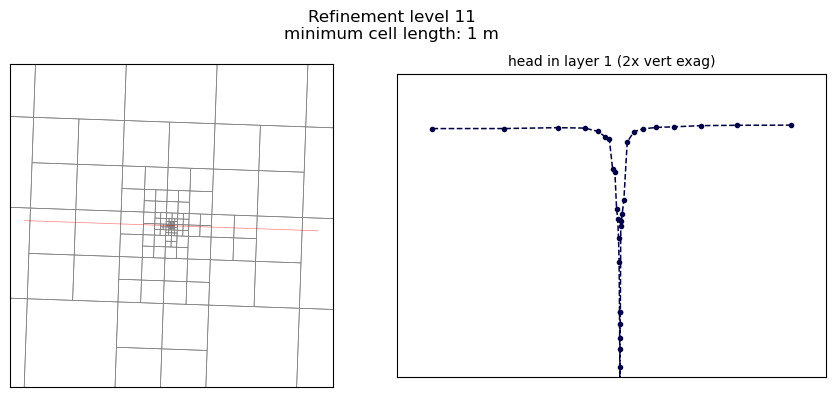

In [91]:
# Plot grids beside drawdown cones and a single plot comparing all drawdown cones
# make shapely linestring and get info
xs_ls = LineString(xs_line)
line_xs, line_ys = xs_ls.xy
line_length = xs_ls.length
center_x, center_y = xs_ls.centroid.coords[0]
# get xylim
zoom_rel_line = 1.1
map_xlim = [center_x - zoom_rel_line/2*line_length, center_x + zoom_rel_line/2*line_length]
map_ylim = [center_y - zoom_rel_line/2*line_length, center_y + zoom_rel_line/2*line_length]
# get colors
cmap = plt.get_cmap('gnuplot2_r')
colors = [cmap(i/(len(all_folders)+3)) for i in range(len(all_folders)+3)][3:]
fig_comb, ax_comb = plt.subplots(figsize=(10, 7.5))
# loop over every one
for i, isim_ws in enumerate(all_folders):
    # Plot 1
    # make figure and axes
    fig, (ax_map, ax_head) = plt.subplots(1, 2, figsize=(9,4))
    # load the gwf object
    igwf = (
        flopy.mf6.MFSimulation
        .load(sim_ws=isim_ws, verbosity_level=0)
        .get_model()
    )
    # load the modelgrid
    modelgrid = igwf.modelgrid
    # get minimum node size
    min_areas = modelgrid.geo_dataframe.geometry.area.min()
    min_length = int(np.round(np.sqrt(min_areas),0))
    # plot the grid, well location, and line
    modelgrid.plot(ax=ax_map, linewidth=0.5)
    ax_map.plot(line_xs, line_ys, lw=0.5, color='red', alpha=0.5)
    ax_map.scatter(well_xy[0], well_xy[1], s=1, color='red')
    # alter axis properties
    ax_map.set_xlim(map_xlim)
    ax_map.set_ylim(map_ylim)
    ax_map.set_aspect('equal')
    remove_axes(ax_map)
    # plot the interpolated heads
    int_lay = well_layer
    plot_interpolated_heads(igwf, xs_line, ax_head, layer=int_lay, linestyle='dashed', 
        grid=False, linewidth=1.1, color=colors[i], marker='.')
    ax_head.set_ylim(-600, 1100)
    ax_head.set_aspect(2)
    ax_head.set_title(f'head in layer {int_lay + 1} (2x vert exag)', fontsize=10)
    remove_axes(ax_head)
    fig.suptitle(f'Refinement level {i}\nminimum cell length: {min_length} m')
    fig.tight_layout()
    # Plot 2
    # plot name
    label = f'Refine {i} - min size: {min_length} m'
    # plot
    plot_interpolated_heads(igwf, xs_line, ax_comb, layer=int_lay, linewidth=1.1, 
        grid=False, color=colors[i], label=label)
ax_comb.set_ylim(-600, 1100)
ax_comb.set_aspect(2)
remove_axes(ax_comb)
ax_comb.legend()
